## Cardianility-Constrained Portfolio Optimisation through Sharpe Ratio

In [1]:
import numpy as np

import utils.helpers as h
from utils.data_loader import get_stock_returns

from algorithms.dfo import DFO
from algorithms.pso import PSO
from algorithms.equal_weights import EqualWeights
from algorithms.monte_carlo import MonteCarlo


 Data: daily percentage returns of top 120 S&P500 companies by market cap (2015-11-06 to 2025-11-04), excluding columns (tickers) with missing/no data (['BRK.B', 'PLTR', 'APP', 'UBER', 'GEV', 'CRWD', 'HOOD', 'CEG', 'DELL']) and rows (days) with missing/no data (e.g. no-trading days, null)

In [ ]:
STARTING_CAPITAL = 10_000
RISK_FREE_RATE = 5.25 / 100
SPLIT_DATE = "2023-11-05"

#N = 50
data = get_stock_returns()
#data = data.iloc[:, :N]


in_sample = data[data.index <= SPLIT_DATE] # Data used to "train"
out_of_sample = data[data.index > SPLIT_DATE] # Data used to "test"

#print(in_sample.head(1))
#print(out_of_sample.head(1))

Loading stock return data...


Sharpe Ratio = (expected return of portfolio – risk-free rate) / portfolio volatility

Maximising this predicts the portfolio with the best risk-adjusted returns.

In [3]:
def _sharpe(weights, returns):
    """Calculates the yearly Sharpe ratio (fitness) for the portfolio.
       Converts daily returns and covariance to trading-yearly values (252 days).

    Args:
        weights (arr): The weight of each asset.
        returns (pd.DataFrame): Daily percentage returns for each asset.

    Returns:
        float: yearly Sharpe ratio 
    """
    po_return = np.sum(returns.mean() * weights) * 252

    covariance = returns.cov() * 252 # Measure of asset trends
    variance = np.dot(weights.T, np.dot(covariance, weights)) # Overall risk
    po_volatility = np.sqrt(variance) # Total risk

    return (po_return - RISK_FREE_RATE) / po_volatility

def _fitness_function(weights):
    return _sharpe(weights, in_sample)


In [ ]:
POPULATION = 100
DISTURBANCE = 0.001  # Best disturbance found
ITERATIONS = 10
CARDINALITY = 10
tickers_amount = data.shape[1]
 
dfo = DFO(
    fitness_function=_fitness_function,
    cardinality=CARDINALITY,
    population=POPULATION,
    dimensions=tickers_amount,
    disturbance=DISTURBANCE,
    max_iterations=ITERATIONS,
    lower_bound=0,
    upper_bound=1,
)

best_dfo_fitness, best_dfo_position = dfo.run()

print("\nFinal best fitness:\t", best_dfo_fitness)
#print("\nBest fly position:\n", best_dfo_position)

h.display_portfolio(best_dfo_position, data);

Iteration: 0	Best fly index: 42	Fitness value: 0.9715810487976907

Final best fitness:	 0.9715810487976907
A portfolio of 10 assets:
GILD   10.52%
DUK    10.52%
AVGO   10.27%
GOOG   10.25%
AMD    10.16%
CDNS    9.78%
APH     9.72%
ABBV    9.68%
COST    9.58%
DHR     9.52%


In [ ]:
OPTIONS = {"c1": 1.5, "c2": 1.5, "w": 0.7}  # Best options found, also the default
pso = PSO(
    fitness_function=_fitness_function,
    cardinality=CARDINALITY,
    population=POPULATION,
    dimensions=tickers_amount,
    max_iterations=ITERATIONS,
    lower_bound=0,
    upper_bound=1,
    options=OPTIONS
)

best_pso_fitness, best_pso_position = pso.run()

print("\nFinal best PSO fitness:\t", best_pso_fitness)
#print("\nBest PSO position:\n", best_pso_position)

h.display_portfolio(best_pso_position, data);

2025-11-25 23:26:09,214 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-1.02
2025-11-25 23:26:10,029 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.0166567959281014, best pos: [0.4535676  0.00315937 0.49596916 0.54230277 0.47293545 0.32898084
 0.22040439 0.89176176 0.87317017 0.41768427 0.73041828 0.88161032
 0.45831003 0.87246871 0.65014217 0.3091802  0.29057418 0.31694225
 0.60063559 0.25628884 0.0863126  0.03388053 0.5613142  0.80692078
 0.56987478 0.41076364 0.35893806 0.6681111  0.29984594 0.68473374
 0.60687304 0.21473128 0.47744115 0.49796906 0.227799   0.53721089
 0.12465757 0.08973777 0.76570993 0.6507368  0.20235915 0.5054704
 0.16627959 0.96836743 0.26692234 0.09603629 0.16845311 0.11032317
 0.30752415 0.34149101]


Best position from optimizer (already constrained): [0.4535676  0.00315937 0.49596916 0.54230277 0.47293545 0.32898084
 0.22040439 0.89176176 0.87317017 0.41768427 0.73041828 0.88161032
 0.45831003 0.87246871 0.65014217 0.3091802  0.29057418 0.31694225
 0.60063559 0.25628884 0.0863126  0.03388053 0.5613142  0.80692078
 0.56987478 0.41076364 0.35893806 0.6681111  0.29984594 0.68473374
 0.60687304 0.21473128 0.47744115 0.49796906 0.227799   0.53721089
 0.12465757 0.08973777 0.76570993 0.6507368  0.20235915 0.5054704
 0.16627959 0.96836743 0.26692234 0.09603629 0.16845311 0.11032317
 0.30752415 0.34149101]
Final portfolio after enforcing constraints again: [0.         0.         0.         0.         0.         0.
 0.         0.10950902 0.10722596 0.         0.08969592 0.10826242
 0.         0.10713982 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.09909048
 0.         0.         0.         0.08204455 0.         0.08408582
 0.         0.     

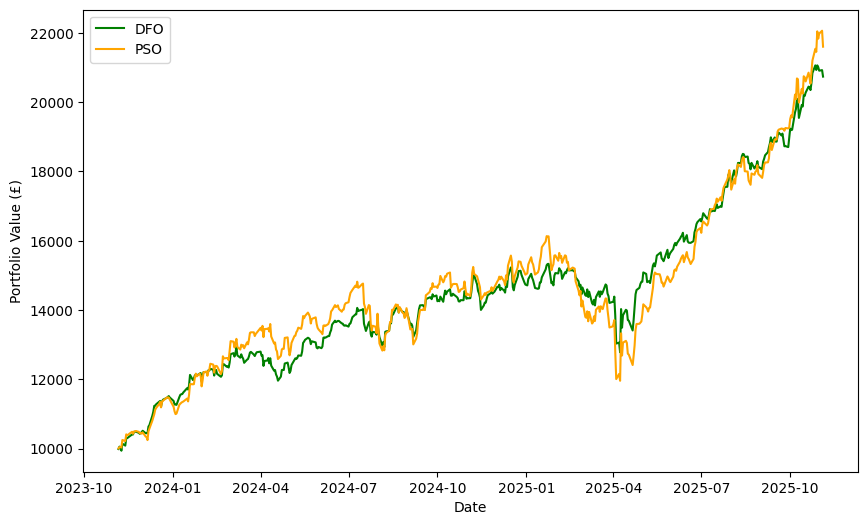

In [6]:
dfo_data = h.get_portfolio_value_over_time(best_dfo_position, out_of_sample, STARTING_CAPITAL)
pso_data = h.get_portfolio_value_over_time(best_pso_position, out_of_sample, STARTING_CAPITAL)

h.plot_dfo_vs_pso(dfo_data, pso_data)

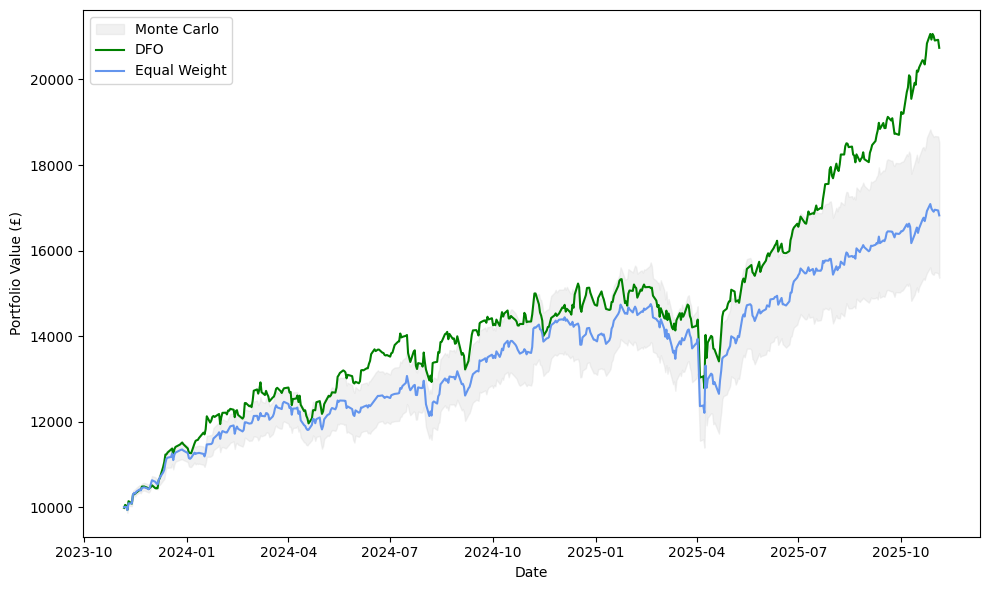

In [7]:
asset_count = out_of_sample.shape[1]

eqw = EqualWeights(portfolio_size=asset_count)
eqw_weights = eqw.get_weights()
eqw_data = h.get_portfolio_value_over_time(eqw_weights, out_of_sample, STARTING_CAPITAL)

mc = MonteCarlo(portfolio_size=asset_count, simulations=100)
mc_data = mc.generate_portfolios(
    out_of_sample, lambda w, r: h.get_portfolio_value_over_time(w, r, STARTING_CAPITAL)
)

h.plot_dfo_vs_benchmark(out_of_sample, dfo_data, eqw_data, mc_data)